In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import norm
from tqdm import trange, tqdm_notebook, tqdm

import math

from collections import OrderedDict


import scanpy as sc
import os


In [2]:
## Load adipose data
UCE_filtered_DIR = '/home/syyang/GitRepo/cs294/finalproject/data/UCEgenes_anndata'

adipose_sn_file = 'adata_with_infer_multiresleiden_toR_Xastypeinteger_proc.h5ad'
adipose_sn_ad = sc.read_h5ad(os.path.join(UCE_filtered_DIR,  adipose_sn_file) )

adipose_sn_ad.obs['sample'] = adipose_sn_ad.obs['sample'].astype('category')
adipose_sn_ad.obs['leiden_scVI_res0.9'] = adipose_sn_ad.obs['leiden_scVI_res0.9'].astype('category')

In [3]:
class scDataset(Dataset):
    def __init__(self, adata):
        """
        adata: AnnData object
        cat: from adata.obs['sample']
        labels: from adata.obs['leiden_scVI_res0.9'] --> Need to be changed to cell type
        """
        self.obs = adata.obs
        self.data = torch.log(torch.tensor(adata.layers['counts'].toarray() + 1. ))  # log transform
        #self.data =  torch.tensor(adata.layers['counts'].toarray())
        self.local_library_mean = self.data.sum(axis=1)
        self.local_library_var = torch.tensor([1.])
        
        self.cat = torch.tensor(adata.obs['sample'].cat.codes.values).to(torch.int64) # sample labels
        self.n_cat = adata.obs['sample'].nunique()
        self.labels = torch.tensor(adata.obs['leiden_scVI_res0.9'].cat.codes.values).to(torch.int64)   # cell type labels
        self.n_labels = adata.obs['leiden_scVI_res0.9'].nunique()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # onehot encode `cat` and `labels`
        cat_onehot = F.one_hot(self.cat[idx], self.n_cat)
        label_onehot = F.one_hot(self.labels[idx], self.n_labels)
        
        return self.data[idx], cat_onehot, label_onehot, self.local_library_mean[idx], self.local_library_var 
    

# Example
adipose_dataset = scDataset(adipose_sn_ad)
data_loader = DataLoader(adipose_dataset, batch_size=10, shuffle=False)
a = next(iter(data_loader))
    

In [4]:
class LinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.1):
        super(LinearBlock, self).__init__()
        layers = [
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim, momentum=.01, eps=0.001),
            nn.ReLU(),
        ]
        if dropout:
            layers.append(nn.Dropout(p=dropout))
            
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

class Encoder_x(nn.Module):
    """_summary_
        This encodes the latent space of the data vector x
    Args:
        nn (_type_): _description_
        latent_dim: 1280, same as the latent_dim in the UCE model (UCE: \ref[Rosen, Yanay, et al. "Universal Cell Embeddings: A Foundation Model for Cell Biology." bioRxiv (2023): 2023-11.])
        
    """
    def __init__(self, input_dim, latent_dim=1280, hidden_dim=1280, hidden_layers=2):
        super(Encoder_x, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[latent_dim, latent_dim]] * (hidden_layers -2) + [[hidden_dim, latent_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        self.linear_mean = nn.Linear(latent_dim, latent_dim)
        self.linear_var = nn.Linear(latent_dim, latent_dim)

    def forward(self, x, cell_type_one_hot):
        x = torch.cat([x, cell_type_one_hot], dim=1) # cell_type_one_hot is the one_hot encoded cell_type_index  
        x = self.layers(x)
        qz_mean = self.linear_mean(x)
        qz_var = torch.exp(self.linear_var(x))
        #z_dist = torch.distributions.Normal(qz_mean, qz_var.sqrt())
        return qz_mean, qz_var #, z_dist
    
    
class Encoder_l(nn.Module):
    """_summary_
        This encodes the library size, which is affected by observation x 
        
    Args:
        nn (_type_): _description_
        latent_dim: 1
        
    """
    def __init__(self, input_dim, latent_dim=1, hidden_dim=20, hidden_layers=2):
        super(Encoder_l, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[latent_dim, latent_dim]] * (hidden_layers -2) + [[hidden_dim, latent_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        self.linear_mean = nn.Linear(latent_dim, latent_dim)
        self.linear_var = nn.Linear(latent_dim, latent_dim)

    def forward(self, x):
        x = self.layers(x)
        ql_mean = self.linear_mean(x)
        ql_var = torch.exp(self.linear_var(x))
        #library_dist = torch.distributions.Normal(ql_mean, ql_var.sqrt())
        return ql_mean, ql_var #, library_dist
    

    
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=1280, hidden_layers=2):
        super(Decoder, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -1) 
        self.decoder = nn.Sequential(
            *[LinearBlock(dim[0], dim[1], dropout=None) for dim in layer_dims]
        )
        
        self.px_dropout_decoder = nn.Sequential(nn.Linear(hidden_dim, output_dim))  # the logit of the dropout rate
        self.px_scale_decoder = nn.Sequential(nn.Linear(hidden_dim, output_dim),
                                      nn.Softmax(dim=-1))
        self.px_dispersion_decoder = nn.Sequential(nn.Linear(hidden_dim, output_dim),
                                                   nn.ReLU())
        

    def forward(self, z, library, cat_one_hot):
        
        input = torch.cat([z, cat_one_hot], dim=1) # cat_index is the one_hot encoded cell_type_index
        x = self.decoder(input)
        
        
        px_scale = self.px_scale_decoder(x)
        px_rate = torch.exp(library) * px_scale

        
        px_dispersion = self.px_dispersion_decoder(x)
        
        px_dropout = self.px_dropout_decoder(x)
        
        return px_rate, px_dispersion, px_dropout 
    
    

    
def log_zinb_positive(
    x: torch.Tensor,
    mu: torch.Tensor,
    theta: torch.Tensor,
    pi: torch.Tensor,
    eps: float = 1e-8,
) -> torch.Tensor:
    """
    Adapted From `https://github.com/scverse/scvi-tools`  with minor modifications
     
    Log likelihood (scalar) of a minibatch according to a zinb model.

    Parameters
    ----------
    x
        Data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    pi
        logit of the dropout parameter (real support) (shape: minibatch x vars)
    eps
        numerical stability constant

    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """
    # theta is the dispersion rate. If .ndimension() == 1, it is shared for all cells (regardless
    # of batch or labels)
    if theta.ndimension() == 1:
        theta = theta.view(1, theta.size(0))  # In this case, we reshape theta for broadcasting

    # Uses log(sigmoid(x)) = -softplus(-x)
    softplus_pi = F.softplus(-pi)
    log_theta_eps = torch.log(theta + eps)
    log_theta_mu_eps = torch.log(theta + mu + eps)
    pi_theta_log = -pi + theta * (log_theta_eps - log_theta_mu_eps)

    case_zero = F.softplus(pi_theta_log) - softplus_pi
    mul_case_zero = torch.mul((x < eps).type(torch.float32), case_zero)

    case_non_zero = (
        -softplus_pi
        + pi_theta_log
        + x * (torch.log(mu + eps) - log_theta_mu_eps)
        + torch.nan_to_num(torch.lgamma(x + theta), posinf=0.)
        - torch.nan_to_num(torch.lgamma(theta), posinf=0.)
        - torch.lgamma(x + 1)
    )
    mul_case_non_zero = torch.mul((x > eps).type(torch.float32), case_non_zero)
    

    # print(f"x[0, 0] is: {x[0,0]}")
    # print(f"torch.lgamma(x + theta)[0, 0] is: {torch.lgamma(x + theta)[0,0]}")
    # print(f"torch.lgamma(theta)[0, 0] is: {torch.lgamma(theta)[0,0]}")

    res = mul_case_zero + mul_case_non_zero

    return res



def log_nb_positive(
    x: torch.Tensor ,
    mu: torch.Tensor ,
    theta: torch.Tensor ,
    eps: float = 1e-8,
    log_fn: callable = torch.log,
    lgamma_fn: callable = torch.lgamma,
) -> torch.Tensor :
    """Log likelihood (scalar) of a minibatch according to a nb model.

    Parameters
    ----------
    x
        data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    eps
        numerical stability constant
    log_fn
        log function
    lgamma_fn
        log gamma function
    """
    log = log_fn
    lgamma = lgamma_fn
    log_theta_mu_eps = log(theta + mu + eps)
    res = (
        theta * (log(theta + eps) - log_theta_mu_eps)
        + x * (log(mu + eps) - log_theta_mu_eps)
        + lgamma(x + theta)
        - lgamma(theta)
        - lgamma(x + 1)
    )

    return res


In [5]:
class snRNAseqVAE(nn.Module):
    def __init__(self, input_dim, output_dim, latent_dim, total_cat, total_cell_type):
        super(snRNAseqVAE, self).__init__()

        self.total_cat = total_cat
        self.total_cell_type = total_cell_type # total_cell_type = total-known-cell-types + 1 (for unknown cell type: 0) 
        
        #self.reconst_loss_fun = -log_zinb_positive
        
        encoder_x_input_dim = input_dim + total_cell_type
        self.encoder_x = Encoder_x(encoder_x_input_dim, latent_dim)
        
        self.encoder_l = Encoder_l(input_dim, 1)
        
        decoder_input_dim = latent_dim + total_cat  # total_cat is the total number of categories in the cat_index, indicates datasets 
        self.decoder = Decoder(decoder_input_dim, output_dim)
        
    def _inference(self, x, cat_one_hot, cell_type_one_hot):
        qz_mean, qz_var = self.encoder_x(x, cell_type_one_hot)
        ql_mean, ql_var = self.encoder_l(x)
        z = torch.distributions.Normal(qz_mean, qz_var.sqrt()).rsample()
        l = torch.distributions.Normal(ql_mean, ql_var.sqrt()).rsample()
        px_rate, px_dispersion, px_dropout  = self.decoder(z, l, cat_one_hot)
        return qz_mean, qz_var, ql_mean, ql_var, px_rate, px_dispersion, px_dropout 
    
    
    def forward(self, x, local_l_mean, local_l_var, cat_one_hot, cell_type_one_hot):
        """_summary_

        Args:
            x (_type_): _description_
            local_l_mean (_type_): shape of [batch_size, 1]
            local_l_var (_type_): shape of [batch_size, 1]
            cat_one_hot (_type_): shape of [batch_size, n_cat]
            cell_type_one_hot (_type_): shape of [batch_size, n_cell_types]

        Returns:
            _type_: _description_
        """
        #local_l_mean =  x.sum(axis=1) outside of this function
        #local_l_var = 0 # should this be within batch? . FInish outside of this function

        
        qz_mean, qz_var, ql_mean, ql_var, px_rate, px_dispersion, px_dropout = self._inference(x, cat_one_hot, cell_type_one_hot)
        # print(f"qz_mean[:, :5] is {qz_mean[:, :5]} \n")
        
        z_dist = torch.distributions.Normal(qz_mean, qz_var.sqrt())
        l_dist = torch.distributions.Normal(ql_mean, ql_var)
        kl_z = torch.distributions.kl.kl_divergence(z_dist, torch.distributions.Normal(torch.zeros_like(qz_mean), torch.ones_like(qz_var))).sum(axis=1)
        kl_l = torch.distributions.kl.kl_divergence(l_dist, torch.distributions.Normal(local_l_mean, local_l_var.sqrt())).sum(axis=1)
        
        
        reconst_loss = -log_zinb_positive(x, px_rate, px_dispersion, px_dropout).mean(axis=-1)
        # print(f"reconst_loss is {reconst_loss}")
        # print(f"reconst_loss shape if of: {reconst_loss.shape}")
        # print(f"kl_z shape if of: {kl_z.shape}")
        # print(f"kl_l shape if of: {kl_l.shape}")
        
        return (reconst_loss + kl_z + kl_l).mean() #, reconst_loss.mean(), kl_z.mean(), kl_l.mean()

#### Change to code cell to run 
#### DEBUGGING
###### prepare data
total_cat = adipose_dataset.obs['sample'].nunique()
total_cell_type = adipose_dataset.obs['leiden_scVI_res0.9'].nunique()
output_dim  = adipose_dataset.data.shape[1]
model = snRNAseqVAE(input_dim=adipose_dataset.data.shape[1], output_dim=output_dim, \
    latent_dim=1280, total_cat=total_cat, total_cell_type=total_cell_type)

optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=0.01)

x, cat_onehot, label_onehot, local_library_mean, local_library_var = next(iter(data_loader))

loss = model(x, local_library_mean, local_library_var, cat_onehot, label_onehot)

for i in loss:
    print(i)

In [6]:
## Training 
def trainning(model, train_loader, device, optimizer, n_epochs=100):
    model = model.to(device)
    model.train()
    train_loss = []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        for i, data in enumerate(train_loader):
            x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
            
            x = x.to(device)
            cat_onehot = cat_onehot.to(device)
            label_onehot = label_onehot.to(device)
            local_library_mean = local_library_mean.to(device)
            local_library_var = local_library_var.to(device)
            
            optimizer.zero_grad()
            loss = model(x, local_library_mean, local_library_var, cat_onehot, label_onehot)
            loss.backward()
            train_loss.append(loss.item())
            optimizer.step()
        print("Epoch: ", epoch, "Loss: ", loss.item())

    return train_loss

In [7]:
adipose_sn_ad.obs['sample'].unique()

['03_SQ', '04_OM', '04_SQ', '05_OM', '06_OM', ..., '01_OM', '01_SQ', '02_OM', '02_SQ', '03_OM']
Length: 22
Categories (22, object): ['03_SQ', '04_OM', '04_SQ', '05_OM', ..., '01_SQ', '02_OM', '02_SQ', '03_OM']

In [9]:
adipose_sn_ad[adipose_sn_ad.obs['sample'] == '03_SQ', ].shape

(823, 15064)

In [10]:
## Data
train_data = adipose_sn_ad[adipose_sn_ad.obs['sample'] == '03_SQ', ]
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=200, shuffle=True)

## set model 
total_cat = adipose_dataset.obs['sample'].nunique()
total_cell_type = adipose_dataset.obs['leiden_scVI_res0.9'].nunique()
output_dim  = adipose_dataset.data.shape[1]
model = snRNAseqVAE(input_dim=adipose_dataset.data.shape[1], output_dim=output_dim, \
    latent_dim=1280, total_cat=total_cat, total_cell_type=total_cell_type)

optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=0.01)

train_loss = trainning(model, data_loader, device='cuda', optimizer=optimizer, n_epochs=200)

  2%|▏         | 3/200 [00:00<00:26,  7.44it/s]

Epoch:  0 Loss:  1054918.75
Epoch:  1 Loss:  1054714.625
Epoch:  2 Loss:  1054944.5


  2%|▎         | 5/200 [00:00<00:20,  9.54it/s]

Epoch:  3 Loss:  1054530.25
Epoch:  4 Loss:  1054627.0
Epoch:  5 Loss:  1054341.5


  4%|▍         | 9/200 [00:00<00:16, 11.53it/s]

Epoch:  6 Loss:  1054648.875
Epoch:  7 Loss:  1054439.875
Epoch:  8 Loss:  1054145.875


  6%|▌         | 11/200 [00:01<00:15, 12.11it/s]

Epoch:  9 Loss:  1054036.375
Epoch:  10 Loss:  1053975.75
Epoch:  11 Loss:  1054087.875


  8%|▊         | 15/200 [00:01<00:14, 12.64it/s]

Epoch:  12 Loss:  1053875.5
Epoch:  13 Loss:  1054214.375
Epoch:  14 Loss:  1054102.125


  8%|▊         | 17/200 [00:01<00:14, 12.77it/s]

Epoch:  15 Loss:  1053960.25
Epoch:  16 Loss:  1053652.625
Epoch:  17 Loss:  1053807.0


 10%|█         | 21/200 [00:01<00:13, 12.93it/s]

Epoch:  18 Loss:  1053858.0
Epoch:  19 Loss:  1053974.5
Epoch:  20 Loss:  1053676.25


 12%|█▏        | 23/200 [00:01<00:13, 12.97it/s]

Epoch:  21 Loss:  1053556.375
Epoch:  22 Loss:  1053593.875
Epoch:  23 Loss:  1053580.375


 14%|█▎        | 27/200 [00:02<00:13, 13.02it/s]

Epoch:  24 Loss:  1053230.75
Epoch:  25 Loss:  1053180.75
Epoch:  26 Loss:  1053319.625


 14%|█▍        | 29/200 [00:02<00:13, 13.01it/s]

Epoch:  27 Loss:  1053196.375
Epoch:  28 Loss:  1053227.375
Epoch:  29 Loss:  1052903.875


 16%|█▋        | 33/200 [00:02<00:12, 13.03it/s]

Epoch:  30 Loss:  1053154.5
Epoch:  31 Loss:  1052787.125
Epoch:  32 Loss:  1053171.0


 18%|█▊        | 35/200 [00:02<00:12, 13.04it/s]

Epoch:  33 Loss:  1052972.25
Epoch:  34 Loss:  1052623.0
Epoch:  35 Loss:  1052833.875


 20%|█▉        | 39/200 [00:03<00:12, 13.06it/s]

Epoch:  36 Loss:  1052767.75
Epoch:  37 Loss:  1053051.0
Epoch:  38 Loss:  1053026.5


 20%|██        | 41/200 [00:03<00:12, 13.05it/s]

Epoch:  39 Loss:  1052595.375
Epoch:  40 Loss:  1052257.125
Epoch:  41 Loss:  1052533.75


 22%|██▎       | 45/200 [00:03<00:11, 13.06it/s]

Epoch:  42 Loss:  1053013.875
Epoch:  43 Loss:  1052797.25
Epoch:  44 Loss:  1052560.0


 24%|██▎       | 47/200 [00:03<00:11, 13.10it/s]

Epoch:  45 Loss:  1051941.375
Epoch:  46 Loss:  1052555.875
Epoch:  47 Loss:  1052156.0


 26%|██▌       | 51/200 [00:04<00:11, 13.08it/s]

Epoch:  48 Loss:  1052131.375
Epoch:  49 Loss:  1052279.5
Epoch:  50 Loss:  1051643.0


 26%|██▋       | 53/200 [00:04<00:11, 13.08it/s]

Epoch:  51 Loss:  1051856.75
Epoch:  52 Loss:  1051825.125
Epoch:  53 Loss:  1051847.25


 28%|██▊       | 57/200 [00:04<00:10, 13.03it/s]

Epoch:  54 Loss:  1051758.75
Epoch:  55 Loss:  1051299.625
Epoch:  56 Loss:  1051588.0


 30%|██▉       | 59/200 [00:04<00:10, 13.03it/s]

Epoch:  57 Loss:  1051189.375
Epoch:  58 Loss:  1051786.25
Epoch:  59 Loss:  1051780.75


 32%|███▏      | 63/200 [00:05<00:10, 12.99it/s]

Epoch:  60 Loss:  1050985.75
Epoch:  61 Loss:  1051249.625
Epoch:  62 Loss:  1051219.375


 32%|███▎      | 65/200 [00:05<00:10, 12.99it/s]

Epoch:  63 Loss:  1050763.5
Epoch:  64 Loss:  1050721.125
Epoch:  65 Loss:  1051098.25


 34%|███▍      | 69/200 [00:05<00:10, 13.02it/s]

Epoch:  66 Loss:  1051378.25
Epoch:  67 Loss:  1050893.875
Epoch:  68 Loss:  1050438.625


 36%|███▌      | 71/200 [00:05<00:09, 13.02it/s]

Epoch:  69 Loss:  1051158.25
Epoch:  70 Loss:  1051518.375
Epoch:  71 Loss:  1050205.625


 38%|███▊      | 75/200 [00:05<00:09, 13.03it/s]

Epoch:  72 Loss:  1051033.875
Epoch:  73 Loss:  1050089.25
Epoch:  74 Loss:  1050858.125


 38%|███▊      | 77/200 [00:06<00:09, 13.03it/s]

Epoch:  75 Loss:  1049915.125
Epoch:  76 Loss:  1050351.125
Epoch:  77 Loss:  1049780.5


 40%|████      | 81/200 [00:06<00:09, 13.03it/s]

Epoch:  78 Loss:  1050710.625
Epoch:  79 Loss:  1050538.5
Epoch:  80 Loss:  1050911.875


 42%|████▏     | 83/200 [00:06<00:08, 13.04it/s]

Epoch:  81 Loss:  1050063.875
Epoch:  82 Loss:  1050260.25
Epoch:  83 Loss:  1049804.75


 44%|████▎     | 87/200 [00:06<00:08, 13.07it/s]

Epoch:  84 Loss:  1049832.875
Epoch:  85 Loss:  1049191.625
Epoch:  86 Loss:  1049555.125


 44%|████▍     | 89/200 [00:07<00:08, 13.07it/s]

Epoch:  87 Loss:  1051516.0
Epoch:  88 Loss:  1050441.5
Epoch:  89 Loss:  1049955.875


 46%|████▋     | 93/200 [00:07<00:08, 12.92it/s]

Epoch:  90 Loss:  1048826.75
Epoch:  91 Loss:  1048745.375
Epoch:  92 Loss:  1049214.625


 48%|████▊     | 95/200 [00:07<00:08, 12.96it/s]

Epoch:  93 Loss:  1048596.25
Epoch:  94 Loss:  1049015.625
Epoch:  95 Loss:  1048903.0


 50%|████▉     | 99/200 [00:07<00:07, 12.91it/s]

Epoch:  96 Loss:  1048335.125
Epoch:  97 Loss:  1048869.75
Epoch:  98 Loss:  1049328.75


 50%|█████     | 101/200 [00:07<00:07, 12.54it/s]

Epoch:  99 Loss:  1048101.0
Epoch:  100 Loss:  1048053.5
Epoch:  101 Loss:  1048422.8125


 52%|█████▎    | 105/200 [00:08<00:07, 12.65it/s]

Epoch:  102 Loss:  1047873.5625
Epoch:  103 Loss:  1048364.375
Epoch:  104 Loss:  1048370.125


 54%|█████▎    | 107/200 [00:08<00:07, 12.76it/s]

Epoch:  105 Loss:  1048725.375
Epoch:  106 Loss:  1048775.125
Epoch:  107 Loss:  1049297.25


 56%|█████▌    | 111/200 [00:08<00:07, 12.70it/s]

Epoch:  108 Loss:  1047429.0625
Epoch:  109 Loss:  1048548.0
Epoch:  110 Loss:  1047771.0


 56%|█████▋    | 113/200 [00:08<00:06, 12.81it/s]

Epoch:  111 Loss:  1046996.5625
Epoch:  112 Loss:  1048203.6875
Epoch:  113 Loss:  1048541.3125


 58%|█████▊    | 117/200 [00:09<00:06, 12.92it/s]

Epoch:  114 Loss:  1047256.625
Epoch:  115 Loss:  1046601.0625
Epoch:  116 Loss:  1046470.1875


 60%|█████▉    | 119/200 [00:09<00:06, 12.87it/s]

Epoch:  117 Loss:  1047787.5625
Epoch:  118 Loss:  1046988.6875
Epoch:  119 Loss:  1046293.75


 62%|██████▏   | 123/200 [00:09<00:05, 12.95it/s]

Epoch:  120 Loss:  1046106.25
Epoch:  121 Loss:  1046044.375
Epoch:  122 Loss:  1047237.3125


 62%|██████▎   | 125/200 [00:09<00:05, 12.97it/s]

Epoch:  123 Loss:  1045900.8125
Epoch:  124 Loss:  1045760.4375
Epoch:  125 Loss:  1047078.125


 64%|██████▍   | 129/200 [00:10<00:05, 13.01it/s]

Epoch:  126 Loss:  1046273.4375
Epoch:  127 Loss:  1046916.375
Epoch:  128 Loss:  1045392.5625


 66%|██████▌   | 131/200 [00:10<00:05, 13.02it/s]

Epoch:  129 Loss:  1046739.125
Epoch:  130 Loss:  1045918.125
Epoch:  131 Loss:  1045125.9375


 68%|██████▊   | 135/200 [00:10<00:04, 13.04it/s]

Epoch:  132 Loss:  1045717.0
Epoch:  133 Loss:  1045669.875
Epoch:  134 Loss:  1046321.0625


 68%|██████▊   | 137/200 [00:10<00:04, 13.04it/s]

Epoch:  135 Loss:  1044766.4375
Epoch:  136 Loss:  1044672.125
Epoch:  137 Loss:  1046088.125


 70%|███████   | 141/200 [00:11<00:04, 12.94it/s]

Epoch:  138 Loss:  1044453.875
Epoch:  139 Loss:  1045907.125
Epoch:  140 Loss:  1045872.25


 72%|███████▏  | 143/200 [00:11<00:04, 12.96it/s]

Epoch:  141 Loss:  1044163.4375
Epoch:  142 Loss:  1044824.875
Epoch:  143 Loss:  1045546.625


 74%|███████▎  | 147/200 [00:11<00:04, 13.01it/s]

Epoch:  144 Loss:  1045383.9375
Epoch:  145 Loss:  1044608.875
Epoch:  146 Loss:  1046138.0


 74%|███████▍  | 149/200 [00:11<00:03, 13.01it/s]

Epoch:  147 Loss:  1044353.9375
Epoch:  148 Loss:  1045143.125
Epoch:  149 Loss:  1043409.875


 76%|███████▋  | 153/200 [00:12<00:03, 12.95it/s]

Epoch:  150 Loss:  1044986.25
Epoch:  151 Loss:  1044010.4375
Epoch:  152 Loss:  1043920.1875


 78%|███████▊  | 155/200 [00:12<00:03, 12.97it/s]

Epoch:  153 Loss:  1044694.5625
Epoch:  154 Loss:  1043731.5
Epoch:  155 Loss:  1043593.125


 80%|███████▉  | 159/200 [00:12<00:03, 13.02it/s]

Epoch:  156 Loss:  1044353.9375
Epoch:  157 Loss:  1043547.75
Epoch:  158 Loss:  1043319.125


 80%|████████  | 161/200 [00:12<00:02, 13.03it/s]

Epoch:  159 Loss:  1042321.5
Epoch:  160 Loss:  1043083.9375
Epoch:  161 Loss:  1043997.9375


 82%|████████▎ | 165/200 [00:12<00:02, 13.05it/s]

Epoch:  162 Loss:  1042863.125
Epoch:  163 Loss:  1041904.1875
Epoch:  164 Loss:  1043900.25


 84%|████████▎ | 167/200 [00:13<00:02, 11.13it/s]

Epoch:  165 Loss:  1042640.375
Epoch:  166 Loss:  1041596.1875


 84%|████████▍ | 169/200 [00:13<00:02, 11.63it/s]

Epoch:  167 Loss:  1042500.125
Epoch:  168 Loss:  1044269.5625
Epoch:  169 Loss:  1041275.0625


 86%|████████▋ | 173/200 [00:13<00:02, 12.17it/s]

Epoch:  170 Loss:  1043101.875
Epoch:  171 Loss:  1041033.5625
Epoch:  172 Loss:  1040904.1875


 88%|████████▊ | 175/200 [00:13<00:02, 12.40it/s]

Epoch:  173 Loss:  1043951.3125
Epoch:  174 Loss:  1040745.6875
Epoch:  175 Loss:  1040629.5625


 90%|████████▉ | 179/200 [00:14<00:01, 12.72it/s]

Epoch:  176 Loss:  1040477.75
Epoch:  177 Loss:  1041560.5625
Epoch:  178 Loss:  1041315.4375


 90%|█████████ | 181/200 [00:14<00:01, 12.82it/s]

Epoch:  179 Loss:  1041281.4375
Epoch:  180 Loss:  1040051.875
Epoch:  181 Loss:  1042070.8125


 92%|█████████▎| 185/200 [00:14<00:01, 12.85it/s]

Epoch:  182 Loss:  1040915.5
Epoch:  183 Loss:  1039732.0
Epoch:  184 Loss:  1040559.0


 94%|█████████▎| 187/200 [00:14<00:01, 12.87it/s]

Epoch:  185 Loss:  1041601.0625
Epoch:  186 Loss:  1041515.5
Epoch:  187 Loss:  1040472.0


 96%|█████████▌| 191/200 [00:15<00:00, 12.97it/s]

Epoch:  188 Loss:  1040285.875
Epoch:  189 Loss:  1038967.6875
Epoch:  190 Loss:  1040981.0625


 96%|█████████▋| 193/200 [00:15<00:00, 12.95it/s]

Epoch:  191 Loss:  1042152.25
Epoch:  192 Loss:  1040370.625
Epoch:  193 Loss:  1040466.6875


 98%|█████████▊| 197/200 [00:15<00:00, 12.98it/s]

Epoch:  194 Loss:  1039289.3125
Epoch:  195 Loss:  1039201.5625
Epoch:  196 Loss:  1040244.5625


100%|██████████| 200/200 [00:15<00:00, 12.73it/s]

Epoch:  197 Loss:  1037733.0625
Epoch:  198 Loss:  1038773.25
Epoch:  199 Loss:  1037453.25


In [11]:
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=500, shuffle=False)
z = []
with torch.no_grad():
    for i, data in enumerate(data_loader):
        x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
        x = x.to('cuda')
        cat_onehot = cat_onehot.to('cuda')
        label_onehot = label_onehot.to('cuda')
        local_library_mean = local_library_mean.to('cuda')
        local_library_var = local_library_var.to('cuda')
        qz_mean, _ = model.encoder_x(x, label_onehot)
        z.append(qz_mean.cpu().detach())

In [13]:
train_data_2 = train_data.copy()
train_data_2.obsm['syy_VAE'] = torch.cat(z).numpy()
sc.pp.neighbors(train_data_2, use_rep='syy_VAE')

In [14]:
sc.tl.umap(train_data_2)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


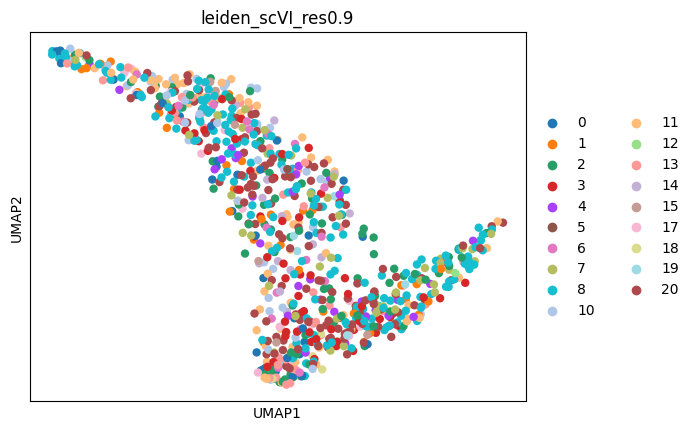

In [16]:
sc.pl.umap(train_data_2, color=['leiden_scVI_res0.9'] )

In [60]:
#adipose_sn_ad_sp2.write_h5ad("/home/syyang/GitRepo/cs294/finalproject/script/adipose_with_VAE20270427.h5ad")

In [30]:
adipose_sn_ad_sp2.obsm['syy_VAE'] = torch.cat(z, dim=0).numpy()

In [31]:
adipose_sn_ad_sp2.obsm['syy_VAE'].shape

(71200, 1280)

In [32]:
sc.pp.neighbors(adipose_sn_ad_sp2, use_rep='syy_VAE')

In [33]:

sc.tl.umap(adipose_sn_ad_sp2, min_dist=0.3)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


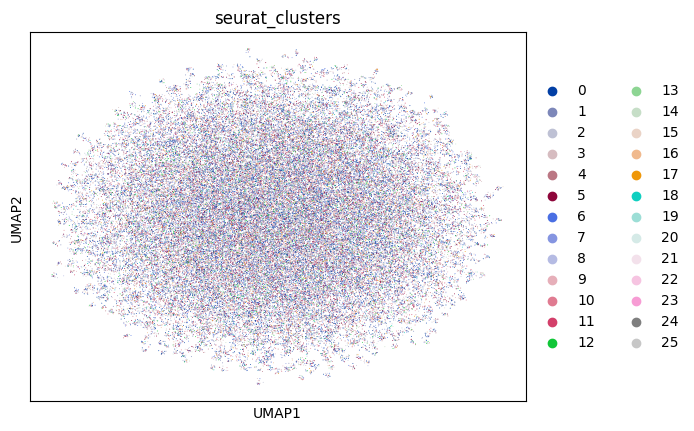

In [34]:
sc.pl.umap(adipose_sn_ad_sp2, color=['seurat_clusters'] )